# adex: exploring the Adaptive Exponential Integrate-and-Fire neuronal model

**Adaptive Exponential Integrate-and-Fire (AdEx) neuronal model**: A two-dimensional integrate-and-fire model that combines an exponential spike mechanism with an adaptation equation:

\begin{align}
C_m \frac{dV}{dt} &= -g_L (V-E_L) + g_L \Delta_T \text{exp} \left( \frac{V-V_T}{\Delta_T} \right) - w + I_e \\
\tau_w \frac{dw}{dt} &= \alpha (V-E_L) - w
\end{align}

- where $C_m$ is the membrane capacitance, $g_L$ and $E_L$ are the leak conductance and reversal potential, respectively. The membrane time contant: \begin{equation}
\tau_m = C_m \cdot R_m = \frac{C_m}{g_L}
\end{equation}

- $\Delta_T$ controls the sharpness of action potential initiation (typical values $ \sim 1 mV$ for pyramidal neurons), $V_T$ denotes the intrinsic membrane potential threshold. Once the membrane potential crosses $V_{T}$, it diverges to infinity in finite time. In numerical simulation the integration is stopped if the membrane potential hits an arbitrary threshold $V_{peak}$ (much larger than $V_{T}$) at which the membrane potential is reset to a value $V_r$.

- $\tau_w$ is the time constant and $\alpha$ represents the level of **subthreshold adaptation**. At each firing time, the variable $w$ is increased by an amount $b$, which accounts for **spike-triggered adaptation**.

Spike mechanism:

\begin{equation}
\text{if } V \ge V_{peak} \text{ then } V → V_r, w → w + b
\end{equation}

In [1]:
!pip install matplotlib==3.7.1 --quiet
!pip install ipympl==0.9.3 --quiet
!pip install brian2==2.5.0.3 --quiet

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  from google.colab import output, widgets
  output.enable_custom_widget_manager()

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [4]:
# @title Make plots nicer  -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

<ipython-input-4-2b9a4f938da3>:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


In [5]:
# Simulation parameters
T = 1200  # ms
dt = 0.1  # ms
steps = int(T/dt)
t_vec = np.linspace(0, T, steps+1)
# External current parameters
Ie_amplitude = 800 # pA
Ie_t1 = 100
Ie_t2 = 1100
# Model Parameters
C = 281  # membrane capacitance in pF
gL = 30  # leaky conductance in nS
EL = -70.6  # leaky reversal potential in mV
VT = -50.4  # threshold in mV
DeltaT = 2  # AP sharpness (slope factor) in mV
Vr = -80  # reset in mV
Vpeak = 20 # peak potential (detection limit) in mV
# Adaptation
tau_w = 144 # adaptation time constant in ms
alpha = 4  # subthreshold adaptation in nS
b = 80.5 # spike-triggered adaptation in pA
# Refractory period
tref = 20  # refractory period in ms (during which neuron cannot spike)
# Vectors
Ie = np.zeros((len(t_vec), ))
V = np.zeros((len(t_vec), ))
w = np.zeros((len(t_vec), ))
# Plot parameters
time_label = 't (ms)'
I_label = 'I (pA)'
V_label = 'V (mV)'
pre_spikes_slider_margin = 0.25
pre_spikes_min = 1
pre_spikes_max = 1000
pre_spikes_slider_valstep = 1
init_pre_spikes = pre_spikes_min

In [6]:
def current(amplitude):
    t1 = Ie_t1
    t2 = Ie_t2
    n1 = int(t1/dt)
    n2 = int(t2/dt)
    Ie[n1:n2 + 1] = amplitude  # current amplitude in pA
    return Ie

In [7]:
def plot(xvec, yvec, xlabel, ylabel, axis=None, title=None, color='blue'):
    if axis is None:
        plt.figure(figsize=(8, 6))
        plt.plot(xvec, yvec, color=color, lw=2)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if title is not None:
            plt.title(title)
        plt.show()
    else:
        axis_line, = axis.plot(xvec, yvec, color=color, lw=2)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        return axis_line

In [8]:
def adex(current, debug=False):
    Ie = current
    V[0] = EL
    w[0] = 0
    tspike = [-1]
    spike_allowed = True
    for n in range(steps):
      dV = (-gL*(V[n]-EL) + gL*DeltaT*np.exp((V[n]-VT)/DeltaT) - w[n] + Ie[n])/C
      V[n+1] = V[n] + dt*dV
      dw = (alpha*(V[n]-EL) - w[n])/tau_w
      w[n+1] = w[n] + dt*dw
      if V[n+1] > Vpeak and spike_allowed:
        t = n*dt
        tspike.append(t)
        if debug:
            print(f'Spike @ {np.round(t, 1)} ms')
        V[n] = Vpeak
        V[n+1] = Vr
        w[n+1] += b
        spike_allowed = False
      if not spike_allowed:
        V[n+1] = Vr
      if n*dt > tref + tspike[-1]:
        spike_allowed = True
    num_spikes = len(tspike[1:])
    return V, w, num_spikes

In [9]:
Ie = current(amplitude=Ie_amplitude)
V, w, num_spikes1 = adex(current=Ie, debug=True)
print(f'Total spikes: {num_spikes1}')

Spike @ 117.9 ms
Spike @ 162.9 ms
Spike @ 212.3 ms
Spike @ 266.1 ms
Spike @ 323.7 ms
Spike @ 384.1 ms
Spike @ 446.3 ms
Spike @ 509.5 ms
Spike @ 573.2 ms
Spike @ 637.2 ms
Spike @ 701.3 ms
Spike @ 765.5 ms
Spike @ 829.7 ms
Spike @ 893.9 ms
Spike @ 958.1 ms
Spike @ 1022.3 ms
Spike @ 1086.5 ms
Total spikes: 17


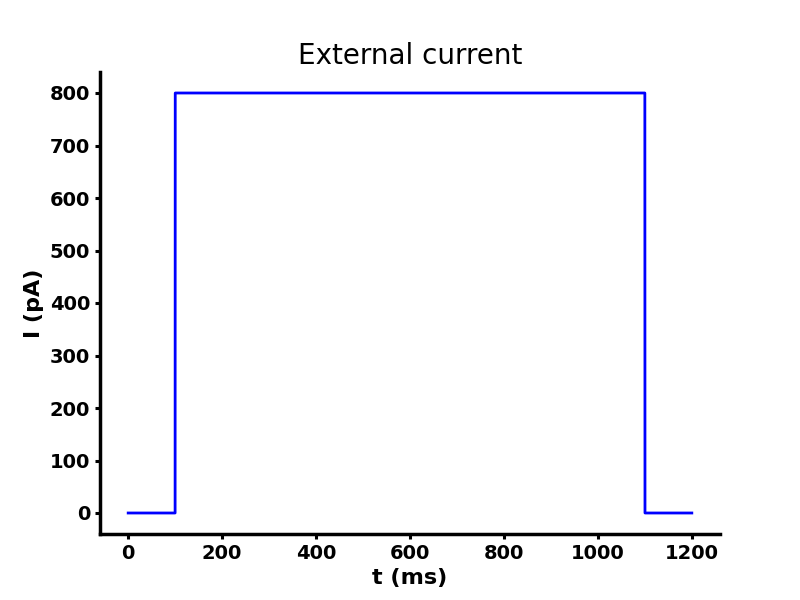

In [10]:
# Plot current
plot(xvec=t_vec, yvec=Ie, xlabel=time_label, ylabel=I_label, title='External current')

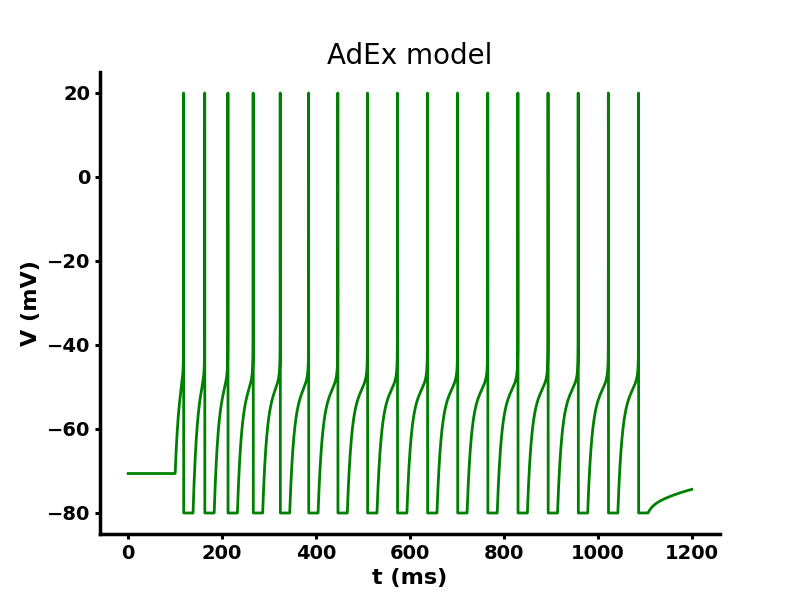

In [11]:
# Plot voltage
plot(xvec=t_vec, yvec=V, xlabel=time_label, ylabel=V_label, title='AdEx model', color='green')

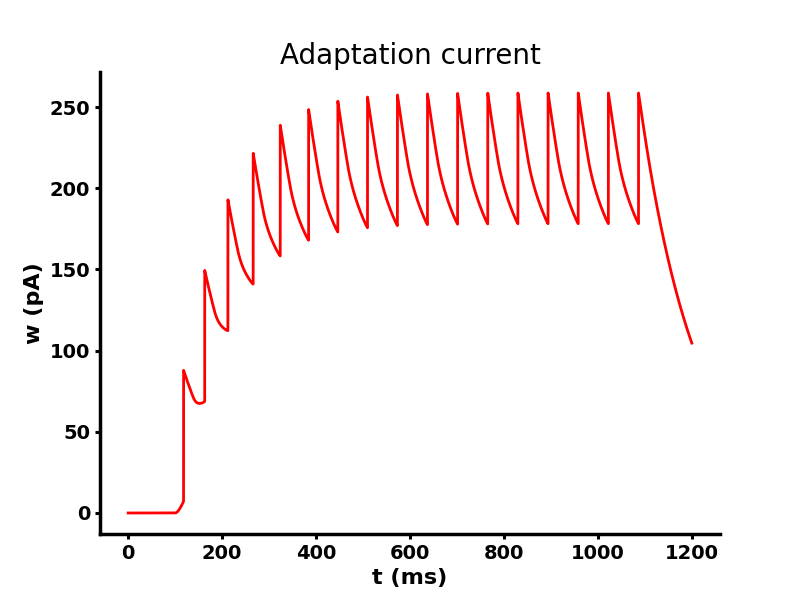

In [12]:
# Plot adaptation current
plot(xvec=t_vec, yvec=w, xlabel=time_label, ylabel='w (pA)', title='Adaptation current', color='red')

### Validating a neuron's experimental evidence

A specific [Neocortex Martinotti cell](https://www.neuroelectro.org/neuron/98/) [(sensorimotor cortex layer 2/3 somatostatin-expressing group 2 cell)](https://www.neuroelectro.org/data_table/492/) (**Halabisky B et al.**) has the following experimental parameters:
- $R_{IN} = 224 ΜΩ$ $(\pm 19)$
- $τ_m = 31.4 ms$ $(\pm 7.7)$
- Steady-state firing frequency $f = 28.8 Hz/nA$ $(\pm 9.0)$

To validate the experimental data, we'll inject a constant current and plot the voltage response. We'll also measure $ΔV$, $R_m$, $\tau_m$ and $f$. Then, we'll tune the model parameters until these values are closer to the experimental ones.

measured_V: -70.82418220767006
tau: 31.25 ms
ΔV: 0.22418220767006858 mV
Rm: 224.18220767006858 MΩ
# spikes before change: 17
# spikes after change: 37
# spikes difference: 20


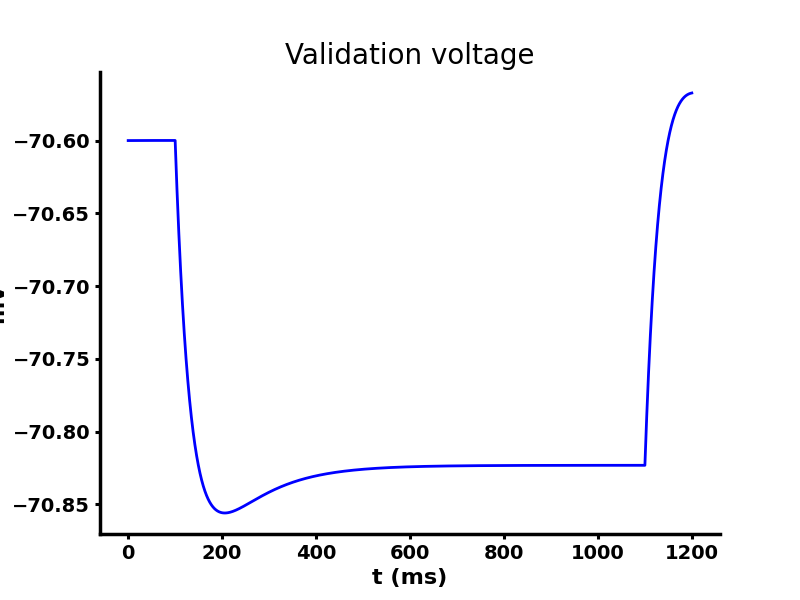

In [13]:
# Model Parameters
scale_factor = 0.0725
C = 1500*scale_factor  # membrane capacitance in pF
gL = 48*scale_factor  # leaky conductance in nS
alpha = 1  # subthreshold adaptation in nS
# Refractory period
frequencyI = 1000  # 1 nA
Ie = current(amplitude=frequencyI)
V, w, num_spikes2 = adex(current=Ie)
validationI = -1  # pA
# Measure voltage value at midpoint of t
Ie = current(amplitude=validationI)
V, w, _ = adex(current=Ie)
measured_V = np.interp(np.median(t_vec), t_vec, V)
ΔV = measured_V - EL  # mV
absΔV = abs(ΔV)*10**-3   # V
I = abs(validationI) * 10**-12  # A
Rm = absΔV/I/10**6  # MΩ
print(f'measured_V: {measured_V}')
tau = C*10**-12/(gL*10**-9) * 10**3  # ms
print(f'tau: {tau} ms')
print(f'ΔV: {abs(ΔV)} mV')
print(f'Rm: {Rm} MΩ')
print(f'# spikes before change: {num_spikes1}')
print(f'# spikes after change: {num_spikes2}')
print(f'# spikes difference: {num_spikes2 - num_spikes1}')
plot(xvec=t_vec, yvec=V, xlabel=time_label, ylabel='mV', title='Validation voltage')

After changing these parameters, even though the current amplitude remains the same, we notice an increase in total spike number.

**Interesting!**

Now, let's plot a F-I plot and see how the spiking frequency changes as a function of the external current when injected for the given time period (about $1 sec$).

In [14]:
# Calculate frequency vector
F_vec = []
I_vec = np.arange(0, 2*Ie_amplitude, 100)
current_duration = (Ie_t2 - Ie_t1) / 1000  # sec
f_at_1nA = None
for i in I_vec:
    ivec = current(amplitude=i)
    V, w, num_spikes = adex(current=ivec)
    f = num_spikes # Hz
    if i == 1000:  # 1000pA == 1nA
        f_at_1nA = f
    F_vec.append(f)

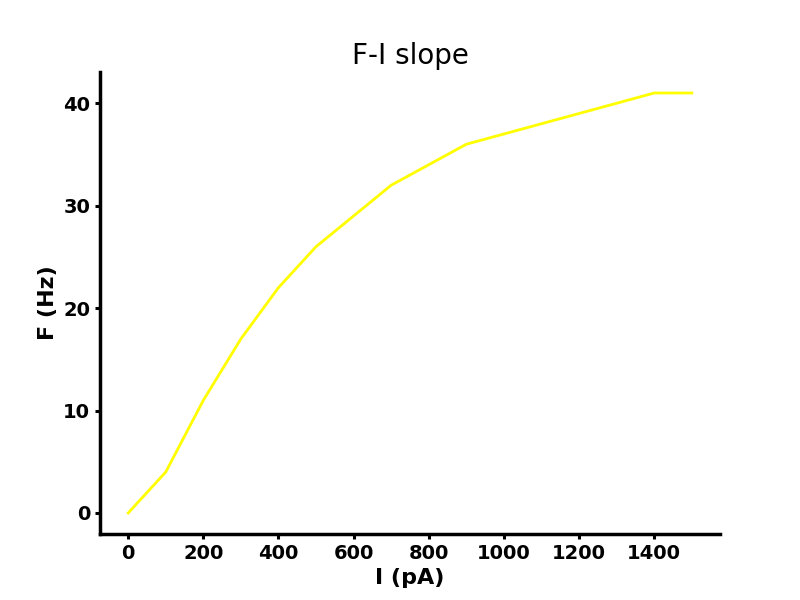

In [15]:
# Plot F-I slope
plot(xvec=I_vec, yvec=F_vec, xlabel=I_label, ylabel='F (Hz)', title='F-I slope', color='yellow')

In [16]:
print(f'Spiking frequency @ 1 nA: {f_at_1nA}')

Spiking frequency @ 1 nA: 37


**Good enough!** The spiking rate falls within the experimental value range: $f_{1nA} = 28.8 \pm 9.0 Hz/nA$.

In [17]:
# Reset model parameters
C = 281  # membrane capacitance in pF
gL = 30  # leaky conductance in nS
alpha = 4  # subthreshold adaptation in nS

### Implementing an excitatory synapse

To simulate an excitatory synapse we replace the constant external current $I_e$ with a synaptic conductance-dependent current $I_{syn}$:

\begin{align}
C_m \frac{dV}{dt} &= -g_L (V-E_L) + g_L \Delta_T \text{exp} \left( \frac{V-V_T}{\Delta_T} \right) - w - I_{syn} \\
I_{syn} &= g_{syn}(t)\left(V-E_{syn}\right) \\
\tau_{syn} \frac{dg_{syn}}{dt} &= -g_{syn} \\
\end{align}

Where $g_{syn}$ is increased by an amount $Δg_{syn}$ on every presynaptic action potential:

\begin{align}
g_{syn} \leftarrow g_{syn} + Δg_{syn}
\end{align}

In [18]:
# Synaptic parameters
Delta_gsyn = 0.5  # nS
tau_syn = 50  # ms
E_syn = 0  # synaptic reversal potential in mV
pre_spikes = [100, 200, 230, 300, 320, 400, 410]  # ms

In [19]:
# Simulation parameters
T = 1000  # ms
dt = 0.1  # ms
steps = int(T/dt)
t_vec = np.linspace(0, T, steps+1)

In [20]:
# Vectors
V = np.zeros((len(t_vec), ))
w = np.zeros((len(t_vec), ))
gsyn = np.zeros((len(t_vec), ))
Isyn = np.zeros((len(t_vec), ))

In [21]:
def adex_syn(pre_spikes):
    w[0] = 0
    V[0] = EL
    gsyn[0] = 0
    tspike = [-1]
    spike_allowed = True
    for n in range(steps):
        Isyn[n] = gsyn[n]*(V[n] - E_syn)
        dV = (-gL*(V[n]-EL) + gL*DeltaT*np.exp((V[n]-VT)/DeltaT) - w[n] - Isyn[n])/C
        V[n+1] = V[n] + dt*dV
        dw = (alpha*(V[n]-EL) - w[n])/tau_w
        w[n+1] = w[n] + dt*dw
        dgsyn = -gsyn[n]/tau_syn
        gsyn[n+1] = gsyn[n] + dt*dgsyn
        if V[n+1] > Vpeak and spike_allowed:
            tspike.append(n*dt)
            V[n] = Vpeak
            V[n+1] = Vr
            w[n+1] += b
            spike_allowed = False
        if not spike_allowed:
            V[n+1] = Vr
        if n*dt > tref + tspike[-1]:
            spike_allowed = True
        if n in [int(j/dt) for j in pre_spikes]:
            gsyn[n+1] += Delta_gsyn
    return V, Isyn

In [22]:
V, Isyn = adex_syn(pre_spikes)

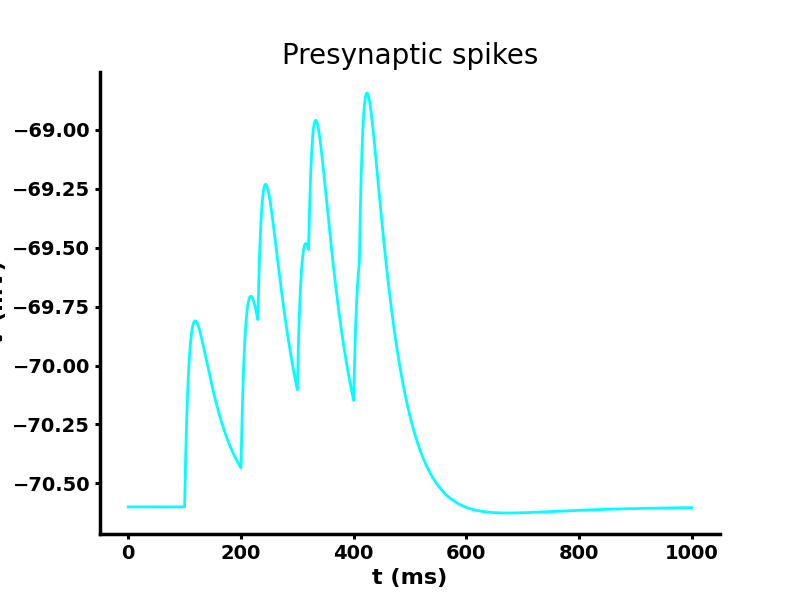

In [23]:
# Plot presynaptic spikes
plot(xvec=t_vec, yvec=V, xlabel=time_label, ylabel=V_label, title='Presynaptic spikes', color='cyan')

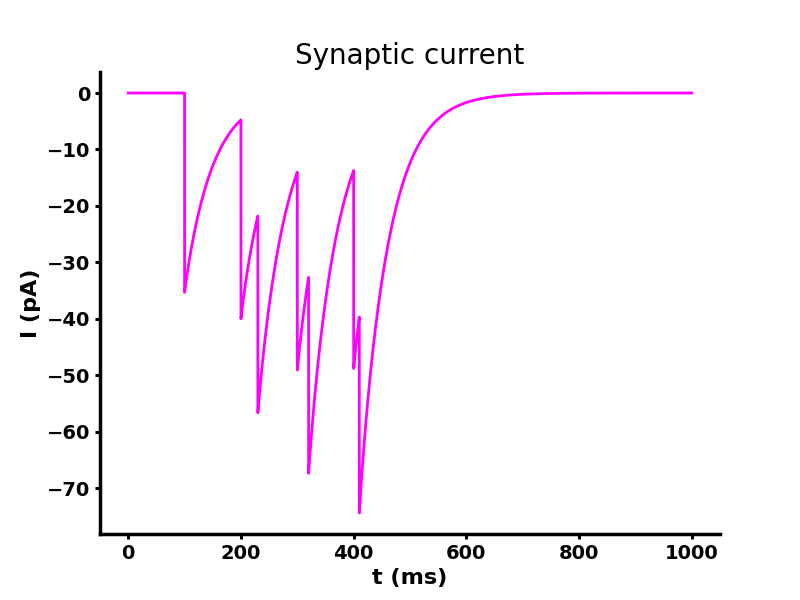

In [24]:
# Plot synaptic current
plot(xvec=t_vec, yvec=Isyn, xlabel=time_label, ylabel=I_label, title='Synaptic current', color='magenta')

For the sake of pure fun, let's create an interactive plot where we can vary the number of random spike times.

In [25]:
def random_spike_times(tmin, tmax, num):
    # Generate randomly spaced data
    t = np.random.random(num + 2).cumsum()
    # Rescale to desired range
    t = (t - t.min()) / t.ptp()
    t = (tmax - tmin) * t + tmin
    return t[1:-1]

In [26]:
def make_update_pre_spikes_callback(fig, V_axis, Isyn_axis):
    def update_pre_spikes(num_pre_spikes):
        new_pre_spikes = random_spike_times(tmin=0, tmax=T, num=num_pre_spikes)
        assert len(new_pre_spikes) == num_pre_spikes
        V, Isyn = adex_syn(new_pre_spikes)
        V_line, = V_axis.get_lines()
        V_line.set_ydata(V)
        V_axis.relim()
        V_axis.autoscale_view()
        Isyn_line, = Isyn_axis.get_lines()
        Isyn_line.set_ydata(Isyn)
        Isyn_axis.relim()
        Isyn_axis.autoscale_view()
        fig.canvas.draw_idle()
    return update_pre_spikes

0

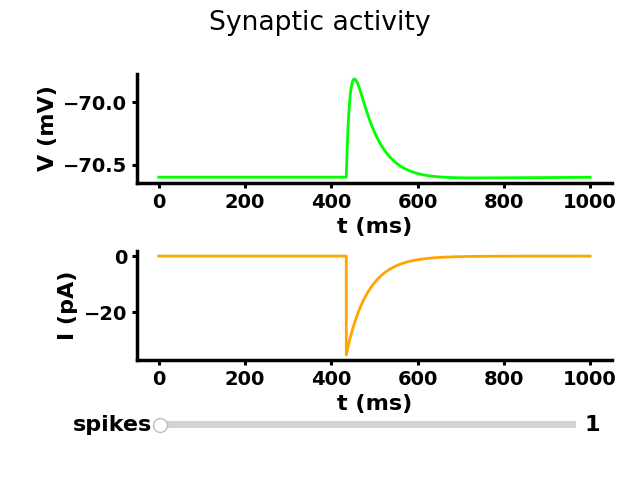

In [27]:
# Plot both presynaptic potential and postsynaptic current
random_spike = random_spike_times(tmin=0, tmax=T, num=pre_spikes_min)
V, Isyn = adex_syn(random_spike)
fig, (V_axis, Isyn_axis) = plt.subplots(2)
fig.suptitle('Synaptic activity')
V_line = plot(xvec=t_vec, yvec=V, xlabel=time_label, ylabel=V_label, axis=V_axis, color='lime')
Isyn_line = plot(xvec=t_vec, yvec=Isyn, xlabel=time_label, ylabel=I_label, axis=Isyn_axis, color='orange')
fig.tight_layout()
# Add horizontal presynaptic spikes slider
plt.subplots_adjust(bottom=pre_spikes_slider_margin)
axspikes = plt.axes([0.25, 0.1, 0.65, 0.03])
pre_spikes_slider = Slider(
    ax=axspikes,
    label='spikes',
    valmin=pre_spikes_min,
    valmax=pre_spikes_max,
    valstep=pre_spikes_slider_valstep,
    valinit=init_pre_spikes,
)
pre_spikes_slider.on_changed(make_update_pre_spikes_callback(fig, V_axis, Isyn_axis))

**Use the slider to adjust the number of spikes.**

**Observations**:
- As we increase the number of **non-AP** spikes, the voltage adds up
- At some point, this voltage accumulation surpasses the $V_{th}$, triggering one or more **AP** spikes
- A large enough number of **non-AP** spikes triggers an ever-increasingly smoother **AP** spike train

### Brian
A more convenient way of simulating the AdEx model is to use the Brain neural network simulator:

In [28]:
# Run the following if brian plots onto previous figures
# Restart kernel
# import os
# os._exit(0)
# Clear previous figures
# plt.figure().clear()
# plt.close()
# plt.cla()
# plt.clf()

In [29]:
%matplotlib widget
from brian2 import *
def adex_brian():
    start_scope()
    C = 281 * pF
    gL = 30 * nS
    taum = C / gL
    EL = -70.6 * mV
    VT = -50.4 * mV
    DeltaT = 2 * mV
    Vcut = VT + 5 * DeltaT
    tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, -70.6*mV
    eqs = """
    dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt
    dw/dt = (a*(vm - EL) - w)/tauw : amp
    I : amp
    """
    neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                         reset="vm=Vr; w+=b", method='euler')
    neuron.vm = EL
    trace = StateMonitor(neuron, 'vm', record=0)
    spikes = SpikeMonitor(neuron)
    run(20 * ms)
    neuron.I = 1*nA
    run(100 * ms)
    neuron.I = 0*nA
    run(20 * ms)
    # We draw nicer spikes
    vm = trace[0].vm[:]
    for t in spikes.t:
        i = int(t / defaultclock.dt)
        vm[i] = 20*mV
    fig, ax = plt.subplots(1)
    ax.plot(trace.t / ms, vm / mV)
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('membrane potential (mV)')
    show()

WARNING    'I' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1e-12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([0.00000000e+00, 0.00000000e+00, 2.43650982e-09, ...,
       3.32561385e-02, 3.32299972e-02, 3.32038765e-02]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


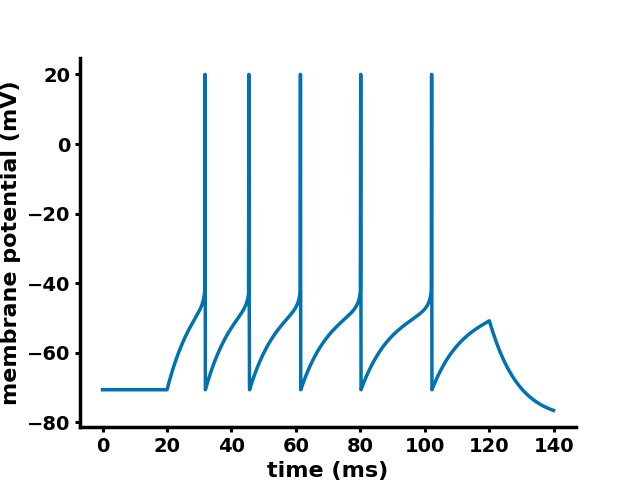

In [30]:
adex_brian()

Brian can be also be used for more complex simulations, such as for learning theories ([STDP](https://brian2.readthedocs.io/en/stable/examples/synapses.STDP.html), etc.).

### References

1. **Brette, R., & Gerstner, W.** (2005). Adaptive exponential integrate-and-fire model as an effective description of neuronal activity. Journal of neurophysiology, 94(5), 3637-3642. doi: [10.1152/jn.00686.2005](https://doi.org/10.1152/jn.00686.2005)
2. [Brian example: Brette Gerstner 2005](https://brian2.readthedocs.io/en/stable/examples/frompapers.Brette_Gerstner_2005.html)